# Beam search 
Effectue une recherche par faisceau (beam search).

**Args:**
        
- start_state (object): L'état initial de la recherche.
- beam_width (int): La taille du faisceau (nombre de candidats à considérer).
- max_steps (int): Le nombre maximum d'étapes à effectuer.
- get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
- evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.

**Returns:**
- object: Le meilleur état trouvé par la beam search.


In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
from tqdm import tqdm
from typing import Callable,List,Tuple,Dict

cmap = plt.get_cmap('tab20') # type: ignore
State=Dict[any,int] # type: ignore

c:\Users\jw_be\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Draw

In [64]:
def draw_graph(G:nx.Graph,state:State=None,label=False):
    if state is None:
        nx.draw(G, node_size = 80, alpha = 0.8)
        plt.show()
    else:
        map= [v for _,v in state.items()]
        u=np.unique(map)
        fixed_map=[np.where(u==i)[0][0] for i in map]
        node_cmap = [cmap(v) for v in fixed_map]
        
        pos = nx.spring_layout(G,seed=40)
        # add label too nodes
        if label:
            labels = {node:node for node in G.nodes()}
            nx.draw_networkx_labels(G, pos, labels, font_size=9)
            
        nx.draw(G, pos, node_size = 80, alpha = 0.8, node_color=node_cmap)
        plt.show()

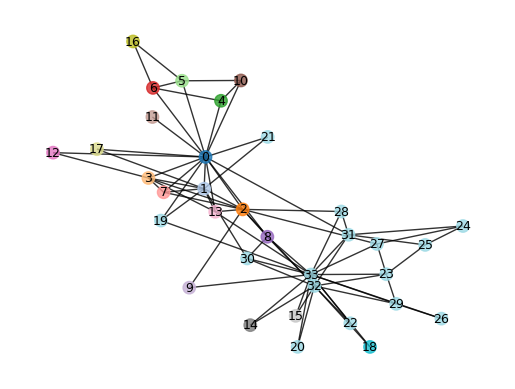

In [3]:
karate_club_graph:nx.Graph = nx.karate_club_graph() # type: ignore
initial_state = {node:i for i,node in enumerate(karate_club_graph.nodes())}
draw_graph(karate_club_graph,initial_state,label=True)

# Utils

In [4]:
def state_partitions(state:State)->List[State]:
    comm_dict = {}
    for node,comm in state.items():
        if comm in comm_dict:
            comm_dict[comm].add(node)
        else:
            comm_dict[comm] = {node}
    return list(comm_dict.values())

In [5]:
def partitions_state(partitions):
    state = {}
    for i,comm in enumerate(partitions):
        for node in comm:
            state[node] = i
    return state

# Initialisation

In [6]:
def init_alea(G:nx.Graph,nb_communities=None)->State:
    if nb_communities is None: nb_communities = len(G.nodes())
    if (nb_communities>len(G.nodes())): raise ValueError("nb_communities must be less than the number of nodes")

    state = {node:np.random.randint(0,nb_communities) for node in G.nodes()}
    return state

In [107]:
def init_greedy(G:nx.Graph)->State:
    partitions= nx.algorithms.community.greedy_modularity_communities(G)
    state=partitions_state(partitions)
    return state

# Fonction de fitness

In [69]:
def modularity(G, state):
    if (len(G.nodes)<=1 or G.number_of_edges()==0): 
        return 0
    partitions = state_partitions(state)
    return nx.algorithms.community.modularity(G, partitions)

In [9]:
modularity(karate_club_graph, initial_state)

-0.05110473941642772

In [10]:
def coverage(G,state):
    """
    how many nodes in a graph are assigned to a community.
    """
    partitions = state_partitions(state)
    return nx.algorithms.community.quality.partition_quality(G,partitions)[0]

In [11]:
coverage(karate_club_graph, initial_state)

0.0

In [12]:
def performance(G,state):
    """
    measure of how well a community detection algorithm partitions the nodes in 
    a graph into communities that reflect the underlying structure of the graph.
    """
    partitions = state_partitions(state)
    return 1- nx.algorithms.community.quality.partition_quality(G,partitions)[1]

In [13]:
performance(karate_club_graph, initial_state)

0.13903743315508021

In [14]:
partitions = state_partitions(initial_state)
np.array(list(partitions))

array([{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12},
       {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23},
       {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}],
      dtype=object)

In [15]:
def cpm_modularity(G,state, gamma=0.5):
    """
    Calculates the modularity score of a graph using the Constant Potts Model (CPM).

    Parameters:
    - Q (nx.Graph): the graph to calculate the modularity score for.
    - gamma (float): the resolution parameter of the CPM.

    Returns:
    - modularity (float): the modularity score of the graph.
    """
    # Get the adjacency matrix of the graph
    A = nx.to_numpy_array(G)
    n = len(A)

    # Get the total weight of the graph
    m = np.sum(A) / 2

    # Calculate the degree of each node
    ki = np.sum(A, axis=1)

    # Calculate the modularity matrix
    B = A - gamma * np.outer(ki, ki) / (2 * m)

    # Calculate the modularity score
    
    partitions = state_partitions(state)
    ci = np.array(list(partitions))
    modularity = 0
    for c in ci:
        c=np.array(list(c))
        modularity += np.sum(B[np.ix_(c, c)])
    modularity /= (2 * m)

    return modularity

In [16]:
cpm_modularity(karate_club_graph,initial_state,0.5)

-0.02555236970821387

# Exploration du voisinage

In [125]:
def vertex_replacement(G:nx.Graph,state:State)->State:
    if(len(set(state.values()))==1):
        return state
    to_replace = np.random.choice(list(state.keys()))
    neighbors = list(G.neighbors(to_replace))
    # get neighbors that are not in the same community
    neighbors = [n for n in neighbors if state[n] != state[to_replace]]
    if len(neighbors)==0:
        return state
        
    replacement = np.random.choice(neighbors)
    new_state = state.copy()
    new_state[to_replace] = state[replacement]
    if modularity(G,new_state) > modularity(G,state):
        return new_state
        
    return state

In [126]:
new_state = vertex_replacement(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 0, 0, 0, 0, 0, 0])


NotAPartition: [{0, 1, 2, 3, 4, 5, 6}] is not a valid partition of the graph Graph named "Zachary's Karate Club" with 34 nodes and 78 edges

In [127]:
partitions = state_partitions(new_state)
np.array(list(partitions))

array([{0, 1, 2, 3, 4, 5, 6}], dtype=object)

In [128]:
def deplacement(G,state:State):
    if(len(set(state.values()))==1):
        return state
    # choose random community
    community = np.random.choice(list(set(state.values())))
    # choose random nodes in community
    community_nodes = [node for node in state.keys() if state[node] == community]
    number_of_nodes_to_move = np.random.randint(1,len(community_nodes))
    nodes_to_move = np.random.choice(community_nodes, number_of_nodes_to_move, replace=False)
    # choose random community to move to
    new_community = np.random.choice(list(set(state.values()) - set([community])))
    new_state = state.copy()
    for node in nodes_to_move:
        new_state[node] = new_community
    if modularity(G,new_state) > modularity(G,state):
        return new_state
    return state

In [21]:
new_state = deplacement(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
-0.05110473941642772


In [133]:
def community_fusion(G,state:State):
    if(len(set(state.values()))==1):
        return state
    # choose random community
    community = np.random.choice(list(set(state.values())))
    # choose random community to fuse with
    new_community = np.random.choice(list(set(state.values()) - set([community])))
    new_state = state.copy()
    for node in new_state.keys():
        if new_state[node] == community:
            new_state[node] = new_community
    if modularity(G,new_state) > modularity(G,state):
        return new_state
    return state

In [23]:
new_state = community_fusion(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
-0.05110473941642772


In [24]:
def exhaustif_cross_mutation(G,history:List[Tuple[float,State]],N:int)->List[Tuple[float,State]]:
    if len(history) < 2:
        return history
    # choose random node
    node = np.random.choice(list(history[-1][1].keys()))
    # get nodes of the same community in every state
    neighbor_communities = []
    for _,state in history:
        comm=state[node]
        nodes_to_cross = [node for node in state.keys() if state[node] == comm]
        neighbor_communities.append(nodes_to_cross)

    states_cross=history.copy()
    for i,(_,state) in enumerate(history):
        for j,neighbor_community in enumerate(neighbor_communities):
            if(i==j):
                continue

            new_state = state.copy()
            for neighbor in neighbor_community:
                new_state[neighbor] = history[j][1][node]
            # check if new state already exists in history
            if(new_state in [state for _,state in states_cross]):
                continue
            mod=modularity(G,new_state)
            candidate = (mod, new_state)
            states_cross.append(candidate)
    
    states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    return states_cross

In [25]:
history = []
heapq.heappush(history, (modularity(karate_club_graph, initial_state), initial_state))
heapq.heappush(history, (modularity(karate_club_graph, new_state), new_state))
history=heapq.nlargest(2, history)
print(history)

[(-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33}), (-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33})]


In [26]:
new_history = exhaustif_cross_mutation(karate_club_graph, history, 5)
print(new_history)

[(-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33}), (-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33})]


In [27]:
def cross_mutation(G:nx.Graph,history:List[Tuple[float,State]],N:int)->List[Tuple[float,State]]:
    if len(history) < 2:
        return history
    # choose random node
    states_cross=history.copy()

    node = np.random.choice(list(history[-1][1].keys()))
    # get two random states in history
    i,j = np.random.choice(range(len(history)), 2, replace=False)
    if i == j:
        return history
        
    state1=history[i][1]
    state2=history[j][1]
    neighbors_1 = [n for n in state1 if state1[n] == state1[node]]
    neighbors_2 = [n for n in state2 if state2[n] == state2[node]]

    new_C2=state2.copy()
    for n in neighbors_1:
        new_C2[n]=state1[node]

    if (not new_C2 in [state for _,state in states_cross]):
        mod=modularity(G,new_C2)
        candidate = (mod, new_C2)
        states_cross.append(candidate)
        states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    new_C1=state1.copy()
    for n in neighbors_2:
        new_C1[n]=state2[node]

    if (not new_C1 in [state for _,state in states_cross]):
        mod=modularity(G,new_C1)
        candidate = (mod, new_C1)
        states_cross.append(candidate)
        states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    return states_cross

In [28]:

mod=modularity(karate_club_graph,initial_state)
candidate = (mod, initial_state)
history:List[Tuple[float, State]]=[candidate]
new_state=initial_state
time=0
while(time<1000):
    new_state=vertex_replacement(karate_club_graph,new_state)
    if(not new_state in [state for _,state in history]):
        mod=modularity(karate_club_graph,new_state)
        candidate = (mod, new_state)
        history.append(candidate)
        history=heapq.nlargest(10, history)
    history = cross_mutation(karate_club_graph, history, 10)
    print(len(history),history[0][0])
    time+=1

2 -0.03116508311313506
3 -0.020426903543786658
3 -0.020426903543786658
4 -0.009220217012424804
5 -0.0023331646708270055
6 0.006221772455538697
7 0.018028147898277776
9 0.02899121080939263
10 0.04374918011281648
10 0.047553456644365735
10 0.053934521466988995
10 0.053934521466988995
10 0.0566331215681865
10 0.0566331215681865
10 0.06203032177058151
10 0.06203032177058151
10 0.06917973801090685
10 0.0721032214538708
10 0.09525683551657577
10 0.10710069151627592
10 0.10710069151627592
10 0.12107156912351717
10 0.12107156912351717
10 0.12107156912351717
10 0.14552763254061954
10 0.14552763254061954
10 0.14552763254061954
10 0.14552763254061954
10 0.14552763254061954
10 0.14552763254061954
10 0.14769213470512166
10 0.14769213470512166
10 0.17043346264125478
10 0.17339442664117982
10 0.19116021064073008
10 0.1912726523116133
10 0.1912726523116133
10 0.1912726523116133
10 0.1912726523116133
10 0.24374543205712032
10 0.24374543205712032
10 0.24374543205712032
10 0.24374543205712032
10 0.243745

In [29]:
class BeamSearch:
    
    G:nx.Graph
    beam:List[Tuple[float,State]]
    best_state:State
    get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]]
    evaluate:Callable[[nx.Graph,State],float]
    beam_width:int
    nb_successors:int

    def __init__(self, G:nx.Graph,start_state:State, get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]], evaluate:Callable[[nx.Graph,State],float], beam_width:int,nb_successors:int):
        """
        Effectue une recherche par faisceau (beam search).

        Args:
            start_state (object): L'état initial de la recherche.
            beam_width (int): La taille du faisceau (nombre de candidats à considérer).
            max_steps (int): Le nombre maximum d'étapes à effectuer.
            get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
            evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.

        Returns:
            object: Le meilleur état trouvé par la beam search.
        """
        self.G = G
        self.beam_width = beam_width
        self.get_successors = get_successors
        self.evaluate = evaluate
        self.beam = [(evaluate(G,start_state), start_state)]
        self.best_state = start_state
        self.nb_successors=nb_successors

    def search(self,max_steps:int):
        for _ in tqdm(range(max_steps)):
            candidates:List[Tuple[float,State]] = []  # Liste pour stocker les nouveaux candidats pour chaque étape
            candidates.extend(self.beam)
            for _, state in self.beam:
                successors = self.get_successors(self.G,state,self.nb_successors)
                # push successors in candidates
                candidates.extend(successors)
            self.beam = heapq.nlargest(self.beam_width, candidates,key=lambda x: x[0])  # Sélectionne les meilleurs candidats, la beam c'est l'ensemble des noeuds accepté dans un niveau.

            if self.evaluate(self.G,self.best_state) < self.beam[0][0]:
                self.best_state = self.beam[0][1]  # Meilleur état trouvé
        
        return self.best_state


In [137]:
voisinage=[vertex_replacement,deplacement,community_fusion]

In [46]:
def get_successors(G:nx.Graph,state:State,N:int)->List[Tuple[float,State]]:
    successors:List[Tuple[float,State]] = []
    for _ in range(N):
        new_state=voisinage[np.random.randint(0,3)](G,state)
        mod=modularity(G,new_state)
        successor=(mod,new_state)
        successors.append(successor)
        
    successors=heapq.nlargest(N, successors,key=lambda x: x[0])
    successors=cross_mutation(G,successors,N)
    return successors

In [32]:
beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=cpm_modularity,beam_width=10,nb_successors=10)

In [35]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

def test(G,p,g_truth):
    return nmi(g_truth,list(p.values()))

In [36]:
g_truth= np.array([karate_club_graph.nodes[i]['club']=='Mr. Hi' for i in range(len(karate_club_graph.nodes))]).astype(int)

In [37]:
import pandas as pd

fitness = ["CPM" , "Performance","Modularity", "Coverage"]
values = []
initial = [cpm_modularity(karate_club_graph,initial_state), performance(karate_club_graph,initial_state),modularity(karate_club_graph,initial_state),coverage(karate_club_graph,initial_state)]
nmilist = []

beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=cpm_modularity,beam_width=10,nb_successors=10)
result = beam.search(max_steps=300)
values.append(cpm_modularity(karate_club_graph,result))
nmilist .append(test(karate_club_graph,result,g_truth))

beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=performance,beam_width=10,nb_successors=10)
result = beam.search(max_steps=300)
values.append(performance(karate_club_graph,result))
nmilist .append(test(karate_club_graph,result,g_truth))

beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=modularity,beam_width=10,nb_successors=10)
result = beam.search(max_steps=300)
values.append(modularity(karate_club_graph,result))
nmilist .append(test(karate_club_graph,result,g_truth))

beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=coverage,beam_width=10,nb_successors=10)
result = beam.search(max_steps=300)
values.append(coverage(karate_club_graph,result))
nmilist .append(test(karate_club_graph,result,g_truth))

100%|██████████| 300/300 [00:22<00:00, 13.44it/s]


In [38]:
df = pd.DataFrame( {
    "fitness" : fitness,
    "valeur initiale" : initial,
    "nouvelle valeur" : values,
    "NMI" : nmilist
})

df

,fitness,valeur initiale,nouvelle valeur,NMI
0,CPM,-0.025552,0.626347,0.615449
1,Performance,0.139037,0.196078,0.587850
2,Modularity,-0.051105,0.444904,0.587850
3,Coverage,0.000000,0.628205,0.506427


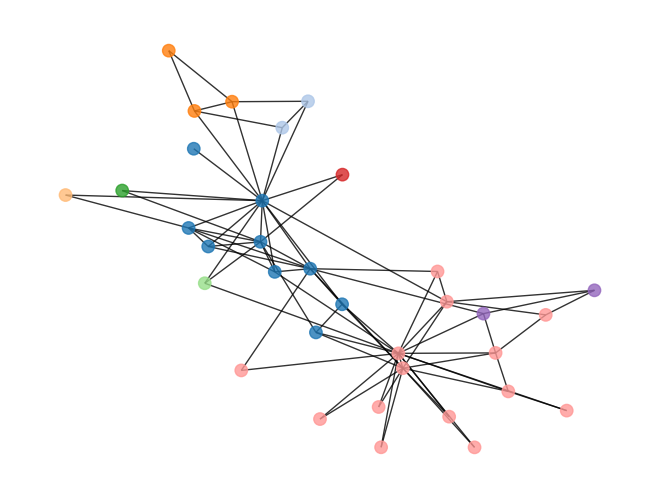

In [39]:
draw_graph(karate_club_graph,result)

In [40]:
beam = []
n = 10
G = karate_club_graph
for i in range(n):
    state = init_alea(G,6)
    beam.append((modularity(G,state),state))

In [41]:
def var(G,beam):
    mod = [ sol[0] for sol in beam]
    mean = sum(mod)/len(beam)
    variance = sum((x - mean) ** 2 for x in mod) / len(mod)
    return variance


In [42]:
var(G,beam)

0.0017232734564595932

In [43]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

def similarity(beam):
    nmi_values = []
    n_partitions = len(beam)
    states = [ sol[1] for sol in beam]
    partitions = [list(state.values()) for state in states]

    for i in range(n_partitions):
        for j in range(i + 1, n_partitions):
            nmi_values.append(nmi(partitions[i], partitions[j]))
    return sum(nmi_values) / len(nmi_values)


In [44]:
similarity(beam)

0.2613734900887521

In [59]:
class BeamSearch_Data:
    
    G:nx.Graph
    beam:List[Tuple[float,State]]
    best_state:State
    get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]]
    evaluate:Callable[[nx.Graph,State],float]
    beam_width:int
    nb_successors:int

    def __init__(self, G:nx.Graph,start_state:State, get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]], evaluate:Callable[[nx.Graph,State],float], beam_width:int,nb_successors:int):
        """
        Effectue une recherche par faisceau (beam search).

        Args:
            start_state (object): L'état initial de la recherche.
            beam_width (int): La taille du faisceau (nombre de candidats à considérer).
            max_steps (int): Le nombre maximum d'étapes à effectuer.
            get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
            evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.

        Returns:
            object: Le meilleur état trouvé par la beam search.
        """
        self.G = G
        self.beam_width = beam_width
        self.get_successors = get_successors
        self.evaluate = evaluate
        self.modularity=evaluate(G,start_state)
        self.beam = [(self.modularity, start_state)]
        self.best_state = start_state
        self.nb_successors=nb_successors
        self.output=[]

    def search(self,max_steps:int):
        for _ in tqdm(range(max_steps)):
            candidates:List[Tuple[float,State]] = []  # Liste pour stocker les nouveaux candidats pour chaque étape
            candidates.extend(self.beam)
            for _, state in self.beam:
                successors = self.get_successors(self.G,state,self.nb_successors)
                # push successors in candidates
                candidates.extend(successors)
            self.beam = heapq.nlargest(self.beam_width, candidates,key=lambda x: x[0])  # Sélectionne les meilleurs candidats, la beam c'est l'ensemble des noeuds accepté dans un niveau.
            variance=var(self.G,self.beam)
            sim=similarity(self.beam)
            delta_mod=self.beam[0][0]-self.modularity
            nodes_num=G.number_of_nodes()
            data={"variance":variance,"similarity":sim,"delta_mod":delta_mod,"size":self.beam_width,"nodes_num":nodes_num}
            self.output.append(data)

            if self.modularity < self.beam[0][0]:
                self.best_state = self.beam[0][1]  # Meilleur état trouvé
                self.modularity = self.beam[0][0]
        
        return self.best_state


In [60]:
beam_data=BeamSearch_Data(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=cpm_modularity,beam_width=10,nb_successors=10)

In [49]:
beam_data.search(max_steps=300)

100%|██████████| 300/300 [00:38<00:00,  7.70it/s]


{0: 17,
 1: 17,
 2: 17,
 3: 17,
 4: 6,
 5: 6,
 6: 6,
 7: 17,
 8: 29,
 9: 29,
 10: 6,
 11: 17,
 12: 17,
 13: 17,
 14: 29,
 15: 29,
 16: 6,
 17: 17,
 18: 29,
 19: 17,
 20: 29,
 21: 17,
 22: 29,
 23: 31,
 24: 31,
 25: 31,
 26: 29,
 27: 31,
 28: 31,
 29: 29,
 30: 29,
 31: 31,
 32: 29,
 33: 29}

In [55]:
beam_data.output

[{'variance': 6.128903139086407e-05,
  'similarity': 0.994170042999741,
  'delta_mod': 0.0,
  'size': 10},
 {'variance': 2.42892610311833e-05,
  'similarity': 0.9800377338846883,
  'delta_mod': 0.008554937126365705,
  'size': 10},
 {'variance': 2.175774128915156e-05,
  'similarity': 0.973250296254789,
  'delta_mod': 0.017025542999568974,
  'size': 10},
 {'variance': 1.360691246745484e-05,
  'similarity': 0.9625588538435653,
  'delta_mod': 0.018890200708382526,
  'size': 10},
 {'variance': 4.006221812492113e-05,
  'similarity': 0.966456154734775,
  'delta_mod': 0.024737167594310435,
  'size': 10},
 {'variance': 1.3339994934972746e-05,
  'similarity': 0.9611517247948309,
  'delta_mod': 0.015263956822398408,
  'size': 10},
 {'variance': 1.553554809836399e-05,
  'similarity': 0.9594375872691486,
  'delta_mod': 0.01508592417683327,
  'size': 10},
 {'variance': 3.342843049209654e-05,
  'similarity': 0.9579806375881534,
  'delta_mod': 0.02057682577163096,
  'size': 10},
 {'variance': 1.998878

In [138]:
datasets=[]
from torch_geometric.datasets import TUDataset
# datasets.append(TUDataset(root='data/TUDataset', name='MUTAG')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='IMDB-BINARY')[0])
datasets.append(TUDataset(root='data/TUDataset', name='IMDB-MULTI')[0])
datasets.append(TUDataset(root='data/TUDataset', name='REDDIT-BINARY')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='REDDIT-MULTI-5K')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='COLLAB')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='PROTEINS')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='DD')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='NCI1')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='NCI109')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='ENZYMES')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='PTC_MR')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='NCI1')[0])
# datasets.append(TUDataset(root='data/TUDataset', name='NCI109')[0])

In [139]:
def get_graph(data):
    G=nx.Graph()
    return nx.Graph(data.edge_index.t().tolist())

In [141]:
DATASET=[]
beam_size=5
while beam_size<10:
    print(beam_size)
    for dataset in datasets:
        G=get_graph(dataset)
        initial_state=init_greedy(G)
        beam_data=BeamSearch_Data(G,start_state=initial_state,get_successors=get_successors,evaluate=modularity,beam_width=beam_size,nb_successors=10)
        beam_data.search(max_steps=300)
        DATASET+=beam_data.output
    beam_size+=5

5


100%|██████████| 300/300 [00:43<00:00,  6.93it/s]


In [142]:
DATASET

[{'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'nodes_num': 7},
 {'variance': 0.0,
  'similarity': 1.0,
  'delta_mod': 0.0,
  'size': 5,
  'node